In [3]:
from anomaly import io, tmm, adm
from sklearn.metrics import f1_score
import pandas as pd
import numpy as np

import anomaly.utils.modelselect_utils as mu
import anomaly.utils.statsutils as su

In [4]:
predictor_dict = {
"naive_predictor" : tmm.NaivePredictor(),
"ar_predictor" : tmm.AR(),
"ma_predictor" : tmm.MA(),
"arma_predictor" : tmm.ARMA(),
"poly_predictor" : tmm.Polynomial(),
}

### Compute the features and the scores of the models for each time series in the benchmark

In [9]:
%%capture --no-stdout

for benchmark_index in range(1,2):
    bench = io.BenchmarkDataset(benchmark_index)

    ## for debug
    #bench.len = 5

    score_dict = mu.compute_predictor_scores(predictor_dict, bench, detector=adm.KSigma())
    score_df = pd.concat([score_dict[model_name].assign(model_name=model_name)
                      for model_name in score_dict.keys()])
    
    score_df.to_csv(f"saved_data/score_df_{benchmark_index}.csv", index_label="ts_index")
    
    features = mu.compute_benchmark_features(bench)
    features.to_csv(f"saved_data/features_{benchmark_index}.csv", index_label="ts_index")

100%|██████████████████████████████████████████████████████| 67/67 [00:10<00:00,  6.32it/s]


### Analyse the results

#### Read the saved data

In [117]:
benchmark_index = 2

In [142]:
score_df = pd.read_csv(f"saved_data/score_df_{benchmark_index}.csv").set_index("ts_index")
features = pd.read_csv(f"saved_data/features_{benchmark_index}.csv").set_index("ts_index")

In [143]:
features_normalized = (features - features.mean()) / features.std()


In [146]:
score_df

,bias,mad,mape,mse,sae,f1,recall,model_name
ts_index,,,,,,,,
0,-3.793342e+00,219.740122,0.364106,9.438015e+04,3.122507e+05,0.400000,1.000000,naive_predictor
1,-2.891046e+00,672.837596,1.509236,7.226477e+05,9.561022e+05,0.285714,1.000000,naive_predictor
2,-1.933118e+00,323.333956,0.955834,1.808965e+05,4.594576e+05,0.285714,1.000000,naive_predictor
3,-1.002302e+01,104.670272,0.034638,5.605039e+05,1.487365e+05,0.400000,0.333333,naive_predictor
4,-5.177551e+00,391.676889,0.404856,3.822769e+05,5.565729e+05,0.400000,0.333333,naive_predictor
...,...,...,...,...,...,...,...,...
95,2.380943e-13,841.113881,1.946935,8.943087e+05,1.195223e+06,0.000000,0.000000,poly_predictor
96,7.520452e-13,881.149629,1.219774,1.065874e+06,1.252114e+06,0.800000,0.666667,poly_predictor
97,2.400784e-12,1021.285236,1.219907,2.093567e+06,1.451246e+06,1.000000,1.000000,poly_predictor


#### Find the best model for each time-series

In [147]:
pivot_init = score_df[["f1", "model_name"]]
df = pd.pivot_table(pivot_init, index="ts_index", columns="model_name", values="f1")

df_np = df.to_numpy()
best_model = df_np.argmax(axis=1)

#### Plot the results depending on the features using PCA

In [149]:
from sklearn import decomposition

features_np = features_normalized.to_numpy()

pca = decomposition.PCA(n_components=2)
XY = pca.fit_transform(features_np)

Text(0.5, 1.0, 'Best model depending on the time-series features, as shown using PCA')

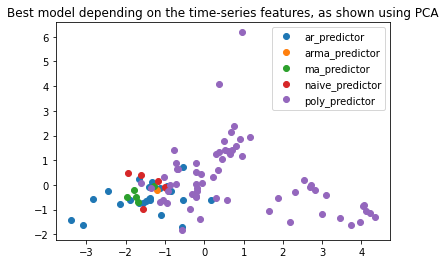

In [150]:
plot_df = pd.DataFrame(XY, columns=["X", "Y"])
plot_df["category"] = np.array(list(predictor_dict.keys()))[best_model]

groups = plot_df.groupby("category")
for name, group in groups:
    plt.plot(group["X"], group["Y"], marker="o", linestyle="", label=name)
plt.legend()
plt.title("Best model depending on the time-series features, as shown using PCA")

### See how each feature affects the fscore using a linear regressionfeatures_normalized

In [152]:
import statsmodels.formula.api as smf


for predictor_name in predictor_dict.keys():
    print(f"------------------------- {predictor_name} --------------------------------")
    score_model_df = score_df[score_df["model_name"] == predictor_name].reset_index(drop=True)
    
    df = features_normalized.join(score_model_df,  on="ts_index")
    
    smresults = smf.ols('f1 ~ trend_score + seasonality_score + nonlinearity + skew + kurtosis + lyapunov', df).fit()
    smresults_robust = smresults.get_robustcov_results()
    print(smresults_robust.summary())

------------------------- naive_predictor --------------------------------
                            OLS Regression Results                            
Dep. Variable:                     f1   R-squared:                       0.256
Model:                            OLS   Adj. R-squared:                  0.208
Method:                 Least Squares   F-statistic:                     5.311
Date:                Wed, 30 Mar 2022   Prob (F-statistic):           9.51e-05
Time:                        15:30:32   Log-Likelihood:                 73.815
No. Observations:                 100   AIC:                            -133.6
Df Residuals:                      93   BIC:                            -115.4
Df Model:                           6                                         
Covariance Type:                  HC1                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------